Note:
*   ham: E-mail that is wanted by the recipient and is not considered spam
*   spam:  E-mail that is considered spam



# A - Spam Email Classification Dataset

## 1 - Import Packages

In [15]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols

# For saving models
import pickle

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashfakyeafi/spam-email-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ashfakyeafi/spam-email-classification/versions/3


In [17]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/ashfakyeafi/spam-email-classification/versions/3/email.csv')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [19]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 2 - EDA

In [20]:
df.duplicated().sum()

415

In [21]:
df.drop_duplicates(inplace=True)

In [22]:
import plotly.express as px

Category_counts = df['Category'].value_counts().reset_index()
Category_counts.columns = ['Category', 'Count']

fig = px.pie(Category_counts,
             names='Category',
             values='Count',
             title='Pie Chart of Email by Category',
             hover_data={'Count': True})

fig.update_traces(textinfo='percent+label',  # Show percentages and labels
                  hovertemplate='Category: %{label}<br>Count: %{value}<br>Percentage: %{percent}')
fig.show()


*   Tỷ trọng Email không Spam là 87.6% với lượng Email không Spam là 4K5 Email
*   Số lượng Email Spam là 13.4% với lượng Email Spam là 641 Email
=> Dataset có thể bị Imbalance dẫn đến dự đoán có thể sai lệch => Điều tra thêm



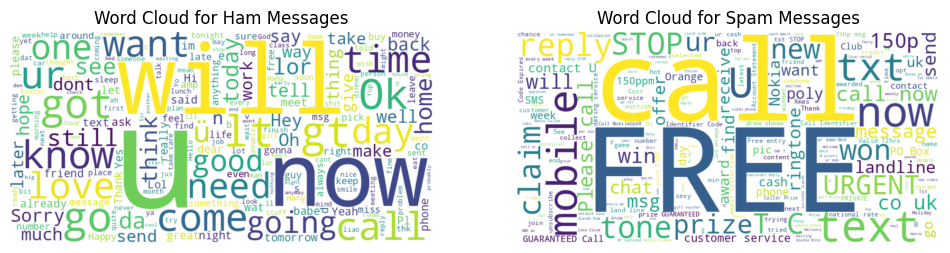

In [23]:
from wordcloud import WordCloud
ham_messages = df[df['Category'] == 'ham']['Message']
spam_messages = df[df['Category'] == 'spam']['Message']

ham_text = ' '.join(ham_messages)
spam_text = ' '.join(spam_messages)

ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.show()

## 3 - Train Model

In [24]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)

In [25]:
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [26]:
X=df['Message']
Y=df['spam']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=42)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

### 3.1 - Decision Tree

**Note:**
CountVectorizer convert text data (e.g., email content, documents) into a numerical format
by counting the occurrences of words (bag-of-words model).
It transforms raw text into a format suitable for machine learning models.

In [29]:
clf_DecisionTree= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('dt',DecisionTreeClassifier())
])

In [30]:
clf_DecisionTree.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('dt', DecisionTreeClassifier())])

In [31]:
y_pred_DT=clf_DecisionTree.predict(X_test)

In [32]:
# Plot Confusion Matrix
conf_mat_DT=confusion_matrix(y_test, y_pred_DT)

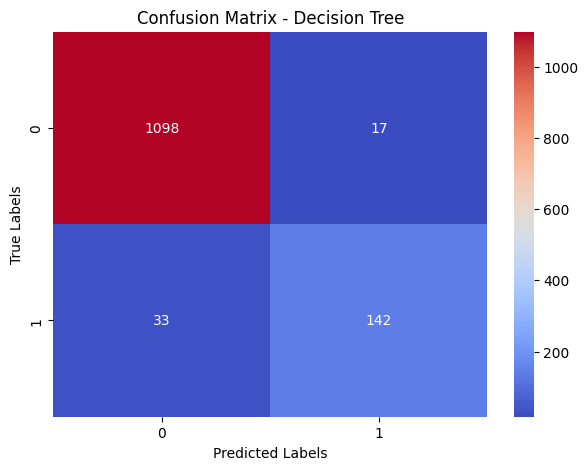

In [33]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_DT,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [34]:
dt_acc=accuracy_score(y_test,y_pred_DT)
dt_acc

0.9612403100775194

Mô hình Decision Tree dự đoán chính xác đến 97.2%

### 3.2 - Random Forest

In [35]:
clf_rf= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100))
])

In [36]:
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('rf', RandomForestClassifier())])

In [37]:
y_pred_RF=clf_rf.predict(X_test)

In [38]:
conf_mat_RF=confusion_matrix(y_test, y_pred_RF)

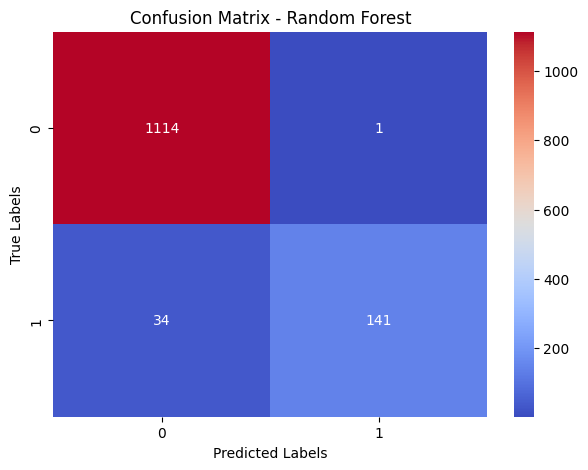

In [39]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_RF,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [40]:
rf_acc=accuracy_score(y_test,y_pred_RF)
rf_acc

0.9728682170542635

Mô hình Random Forest dự đoán chính xác đến 97.77%

### 3.3 - Naive Bayes

In [41]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
clf_NaiveBaised= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nd', MultinomialNB())
])

In [42]:
clf_NaiveBaised.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nd', MultinomialNB())])

In [43]:
y_pred_NB=clf_NaiveBaised.predict(X_test)

In [44]:
conf_mat_NB=confusion_matrix(y_test, y_pred_NB)

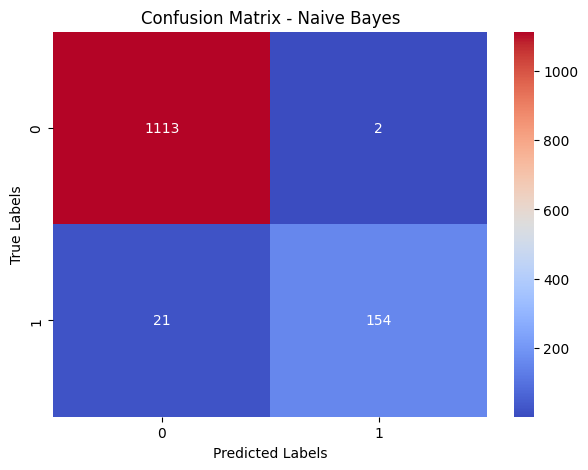

In [45]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_NB,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [46]:
naive_acc=accuracy_score(y_test,y_pred_NB)
naive_acc

0.982170542635659

Mô hình Naive Bayes dự đoán chính xác đến 98.56%

### 3.4 - Model Evaluation

In [47]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Assuming you have `y_test` (true labels) and `y_pred` (predicted labels) from the model:
y_pred = clf_rf.predict(X_test)  # Replace `clf_rf` with your pipeline or model object

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate and print the classification report
report = classification_report(y_test, y_pred, target_names=['ham', 'spam'])
print(report)

# Optional: Print confusion matrix for further analysis
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.97
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1115
        spam       0.99      0.81      0.89       175

    accuracy                           0.97      1290
   macro avg       0.98      0.90      0.94      1290
weighted avg       0.97      0.97      0.97      1290

Confusion Matrix:
 [[1114    1]
 [  34  141]]


## 4 - Testing the Model

In [48]:
def spam_dect(clf,txt):
    a=clf.predict([txt])
    if a==1:
        print("This is a Spam email")
    else:
        print("This is a Real email")

In [49]:
#Demo email, copy the content into the " "
test_email_1="Call Us now for free" #Spam Email from my mail box
test_email_2="Notification of rank change. Project: demart.com.vn"   #Real Email from my mail box

In [50]:
#Predict with Naive Bayes
spam_dect(clf_NaiveBaised,test_email_1)

This is a Spam email


In [51]:
spam_dect(clf_NaiveBaised,test_email_2)

This is a Real email


# B - The Spam Email Dataset

## 1 - Import Packages

In [450]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols

# For saving models
import pickle

In [451]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jackksoncsie/spam-email-dataset/versions/1


In [452]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/jackksoncsie/spam-email-dataset/versions/1/emails.csv')

In [453]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [454]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [455]:
df.duplicated().sum()

33

In [456]:
df.drop_duplicates(inplace=True)

## 2 - EDA

0 - Ham Emails, 1 - Spam Email

In [97]:
import plotly.express as px

Category_counts = df['spam'].value_counts().reset_index()
Category_counts.columns = ['spam', 'Count']

fig = px.pie(Category_counts,
             names='spam',
             values='Count',
             title='Pie Chart of Email by Category',
             hover_data={'Count': True})

fig.update_traces(textinfo='percent+label',  # Show percentages and labels
                  hovertemplate='Category: %{label}<br>Count: %{value}<br>Percentage: %{percent}')
fig.show()

In [458]:
df['Spam_Status'] = df['spam'].apply(lambda x: 'spam' if x == 1 else 'ham')

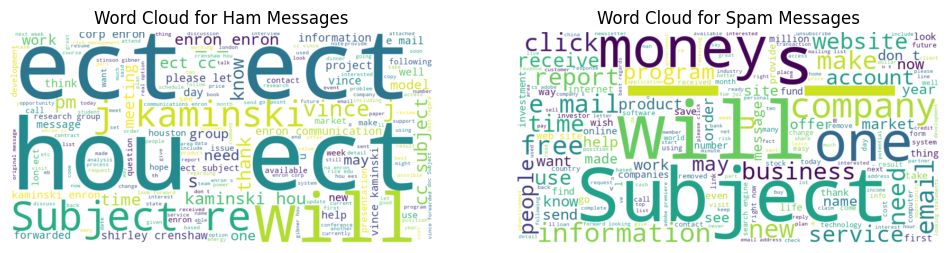

In [461]:
from wordcloud import WordCloud
ham_messages = df[df['Spam_Status'] == 'ham']['text']
spam_messages = df[df['Spam_Status'] == 'spam']['text']

ham_text = ' '.join(ham_messages)
spam_text = ' '.join(spam_messages)

ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.show()

## 3 - Train Model

In [103]:
X=df['text']
Y=df['spam']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=42)

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

### 3.1 - Decision Tree

In [106]:
clf_DecisionTree= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('dt',DecisionTreeClassifier())
])

In [107]:
clf_DecisionTree.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('dt', DecisionTreeClassifier())])

In [108]:
y_pred_DT=clf_DecisionTree.predict(X_test)

In [109]:
# Plot Confusion Matrix
conf_mat_DT=confusion_matrix(y_test, y_pred_DT)

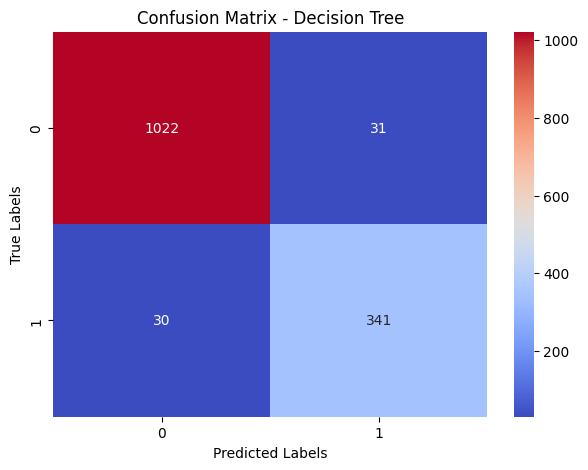

In [110]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_DT,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [111]:
dt_acc=accuracy_score(y_test,y_pred_DT)
dt_acc

0.9571629213483146

### 3.2 - Random Forest

In [112]:
clf_rf= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100))
])

In [113]:
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('rf', RandomForestClassifier())])

In [114]:
y_pred_RF=clf_rf.predict(X_test)

In [115]:
conf_mat_RF=confusion_matrix(y_test, y_pred_RF)

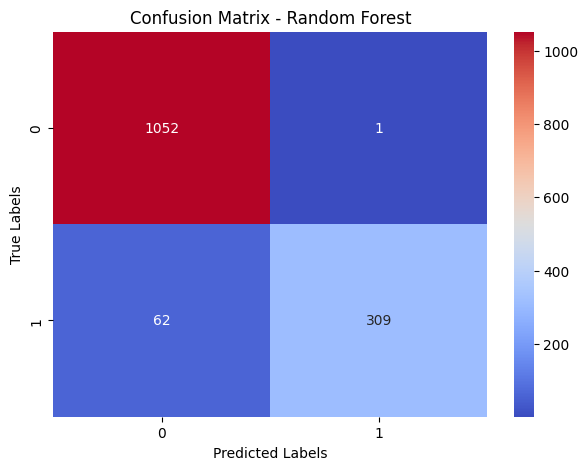

In [116]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_RF,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [118]:
rf_acc=accuracy_score(y_test,y_pred_RF)
rf_acc

0.9557584269662921

### 3.3 - Naive Bayes

In [119]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
clf_NaiveBaised= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nd', MultinomialNB())
])

In [120]:
clf_NaiveBaised.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nd', MultinomialNB())])

In [121]:
y_pred_NB=clf_NaiveBaised.predict(X_test)

In [122]:
conf_mat_NB=confusion_matrix(y_test, y_pred_NB)

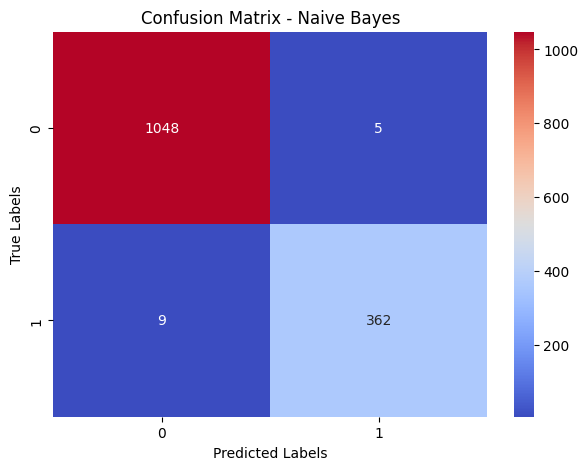

In [123]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_NB,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [124]:
naive_acc=accuracy_score(y_test,y_pred_NB)
naive_acc

0.9901685393258427

## 4 - Testing the Model

In [125]:
def spam_dect(clf,txt):
    a=clf.predict([txt])
    if a==1:
        print("This is a Spam email")
    else:
        print("This is a Real email")

In [139]:
#Demo email, copy the content into the " "
test_email_1="Did you just add this phone number?" #Spam Email from my mail box
test_email_2="2024 Wrapped: How Microsoft Clarity Evolved for Better Analytics"   #Real Email from my mail box

In [140]:
#Predict with Naive Bayes
spam_dect(clf_NaiveBaised,test_email_1)

This is a Real email


In [141]:
spam_dect(clf_NaiveBaised,test_email_2)

This is a Spam email


# C - The Phising Email Dataset

## 1 - Import Packages

In [462]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols

# For saving models
import pickle

In [463]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subhajournal/phishingemails")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/subhajournal/phishingemails/versions/1


In [464]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/subhajournal/phishingemails/versions/1/Phishing_Email.csv')

In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [466]:
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [467]:
df['spam']=df['Email Type'].apply(lambda x: 1 if x=='Phishing Email' else 0)

In [468]:
df.head()

,Unnamed: 0,Email Text,Email Type,spam
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,1,the other side of * galicismos * * galicismo *...,Safe Email,0
2,2,re : equistar deal tickets are you still avail...,Safe Email,0
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email,1


In [469]:
df.duplicated().sum()

0

In [470]:
df.drop_duplicates(inplace=True)

In [471]:
df['Email Text'].isnull().sum()

16

In [472]:
df = df.dropna(subset=['Email Text'])

## 2 - EDA

0 - Ham Emails, 1 - Spam Email

In [151]:
import plotly.express as px

Category_counts = df['spam'].value_counts().reset_index()
Category_counts.columns = ['spam', 'Count']

fig = px.pie(Category_counts,
             names='spam',
             values='Count',
             title='Pie Chart of Email by Category',
             hover_data={'Count': True})

fig.update_traces(textinfo='percent+label',  # Show percentages and labels
                  hovertemplate='Category: %{label}<br>Count: %{value}<br>Percentage: %{percent}')
fig.show()

In [473]:
df.head(1)

,Unnamed: 0,Email Text,Email Type,spam
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0


In [474]:
df['Spam_Status'] = df['spam'].apply(lambda x: 'spam' if x == 1 else 'ham')

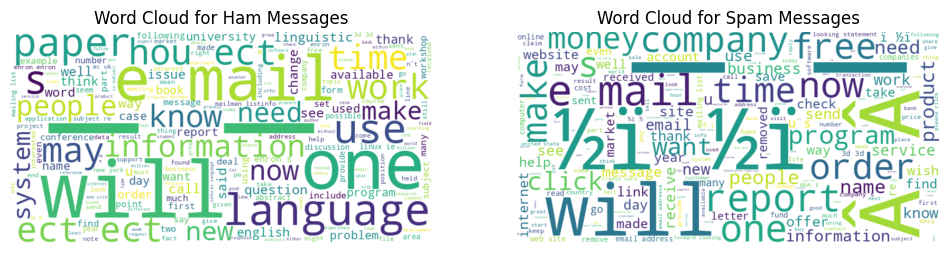

In [475]:
from wordcloud import WordCloud
ham_messages = df[df['Spam_Status'] == 'ham']['Email Text']
spam_messages = df[df['Spam_Status'] == 'spam']['Email Text']

ham_text = ' '.join(ham_messages)
spam_text = ' '.join(spam_messages)

ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.show()

## 3 - Train Model

In [164]:
X=df['Email Text']
Y=df['spam']

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=42)

In [166]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

### 3.1 - Decision Tree

In [167]:
clf_DecisionTree= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('dt',DecisionTreeClassifier())
])

In [168]:
clf_DecisionTree.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('dt', DecisionTreeClassifier())])

In [169]:
y_pred_DT=clf_DecisionTree.predict(X_test)

In [170]:
# Plot Confusion Matrix
conf_mat_DT=confusion_matrix(y_test, y_pred_DT)

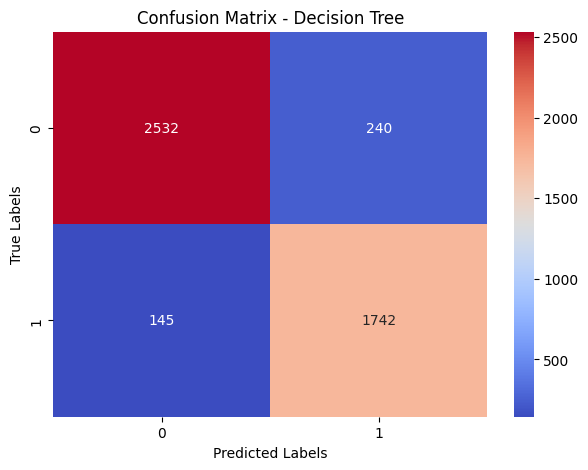

In [171]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_DT,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [172]:
dt_acc=accuracy_score(y_test,y_pred_DT)
dt_acc

0.9173642412534879

### 3.2 - Random Forest

In [173]:
clf_rf= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100))
])

In [174]:
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('rf', RandomForestClassifier())])

In [175]:
y_pred_RF=clf_rf.predict(X_test)

In [176]:
conf_mat_RF=confusion_matrix(y_test, y_pred_RF)

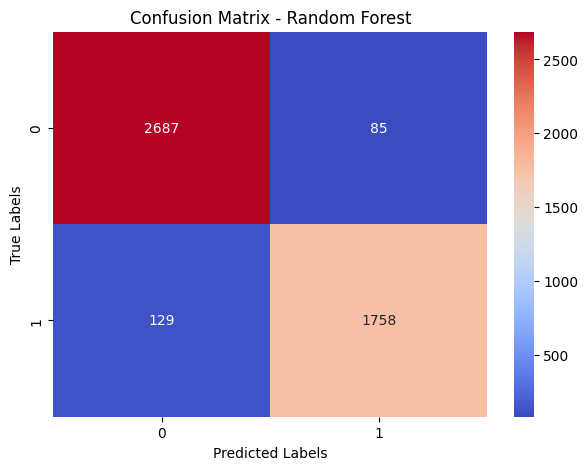

In [177]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_RF,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [178]:
rf_acc=accuracy_score(y_test,y_pred_RF)
rf_acc

0.9540673964370037

### 3.3 - Naive Bayes

In [179]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
clf_NaiveBaised= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nd', MultinomialNB())
])

In [180]:
clf_NaiveBaised.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nd', MultinomialNB())])

In [181]:
y_pred_NB=clf_NaiveBaised.predict(X_test)

In [182]:
conf_mat_NB=confusion_matrix(y_test, y_pred_NB)

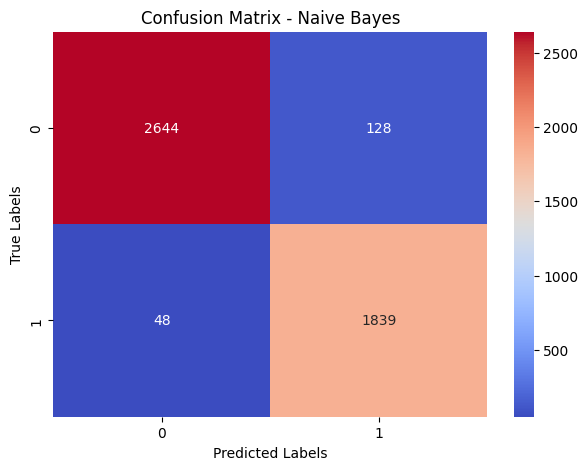

In [183]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_NB,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [184]:
naive_acc=accuracy_score(y_test,y_pred_NB)
naive_acc

0.9622236531444516

## 4 - Testing the Model

In [185]:
def spam_dect(clf,txt):
    a=clf.predict([txt])
    if a==1:
        print("This is a Spam email")
    else:
        print("This is a Real email")

In [201]:
#Demo email, copy the content into the " "
test_email_1="A Special New Year's Edition Newsletter! | Good Smile Company Newsletter 2024.12.26" #Spam Email from my mail box
test_email_2="iBankUAT 1.6.4 (39) for iOS is ready to test"   #Real Email from my mail box

In [202]:
#Predict with Naive Bayes
spam_dect(clf_NaiveBaised,test_email_1)

This is a Spam email


In [203]:
spam_dect(clf_NaiveBaised,test_email_2)

This is a Real email


# D - Join All 3 Datasets

## 1 - Import Packages

In [476]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols

# For saving models
import pickle

In [477]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashfakyeafi/spam-email-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ashfakyeafi/spam-email-classification/versions/3


In [478]:
df1 = pd.read_csv('/root/.cache/kagglehub/datasets/ashfakyeafi/spam-email-classification/versions/3/email.csv')

In [479]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jackksoncsie/spam-email-dataset/versions/1


In [480]:
df2 = pd.read_csv('/root/.cache/kagglehub/datasets/jackksoncsie/spam-email-dataset/versions/1/emails.csv')

In [481]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subhajournal/phishingemails")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/subhajournal/phishingemails/versions/1


In [482]:
df3 = pd.read_csv('/root/.cache/kagglehub/datasets/subhajournal/phishingemails/versions/1/Phishing_Email.csv')

## 2 - Clean Data

### 2.1 - Dataset 1

In [483]:
df1.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [484]:
df1.duplicated().sum()

415

In [485]:
df1.drop_duplicates(inplace=True)

In [486]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5158 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5158 non-null   object
 1   Message   5158 non-null   object
dtypes: object(2)
memory usage: 120.9+ KB


### 2.2 - Dataset 2

In [487]:
df2.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [488]:
df2.duplicated().sum()

33

In [489]:
df2.drop_duplicates(inplace=True)

In [490]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5695 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5695 non-null   object
 1   spam    5695 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.5+ KB


### 2.3 - Dataset 3

In [491]:
df3.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [492]:
df3.duplicated().sum()

0

In [493]:
df3.drop_duplicates(inplace=True)

In [494]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


### 2.4 - Merge Data

In [495]:
df1['spam']=df1['Category'].apply(lambda x: 1 if x=='spam' else 0)

In [496]:
df1.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [497]:
df2.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [498]:
df3['spam']=df3['Email Type'].apply(lambda x: 1 if x=='Phishing Email' else 0)

In [499]:
df3.head()

,Unnamed: 0,Email Text,Email Type,spam
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,1,the other side of * galicismos * * galicismo *...,Safe Email,0
2,2,re : equistar deal tickets are you still avail...,Safe Email,0
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email,1


In [500]:
df3 = df3.drop(columns=['Unnamed: 0','Email Type'])

In [501]:
df3.head()

,Email Text,spam
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1


In [502]:
df1 = df1.drop(columns=['Category'])

In [503]:
df1.head()

,Message,spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [504]:
# Rename the Column the same as Dataset 1
df2 = df2.rename(columns={'text': 'Message'})
df3 = df3.rename(columns={'Email Text': 'Message'})

In [505]:
df2.head()

,Message,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [506]:
df3.head()

,Message,spam
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1


In [507]:
df = pd.concat([df1, df2, df3], ignore_index=True)

In [508]:
df.head()

,Message,spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [509]:
df['Message'].isnull().sum()

16

In [510]:
df = df.dropna()

## 3 - EDA & Train Model

### 3.1 - EDA

0 - Ham Emails, 1 - Spam Emails

In [511]:
import plotly.express as px

Category_counts = df['spam'].value_counts().reset_index()
Category_counts.columns = ['spam', 'Count']

fig = px.pie(Category_counts,
             names='spam',
             values='Count',
             title='Pie Chart of Email by Category',
             hover_data={'Count': True})

fig.update_traces(textinfo='percent+label',  # Show percentages and labels
                  hovertemplate='Category: %{label}<br>Count: %{value}<br>Percentage: %{percent}')
fig.show()

In [512]:
df['Spam_Status'] = df['spam'].apply(lambda x: 'spam' if x == 1 else 'ham')

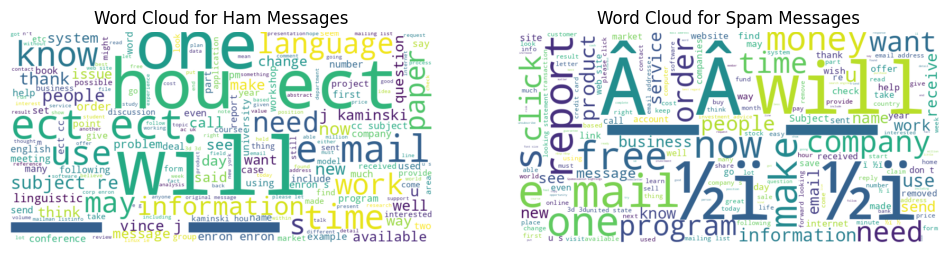

In [513]:
from wordcloud import WordCloud
ham_messages = df[df['Spam_Status'] == 'ham']['Message']
spam_messages = df[df['Spam_Status'] == 'spam']['Message']

ham_text = ' '.join(ham_messages)
spam_text = ' '.join(spam_messages)

ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.show()

### 3.2 - Train Model

In [337]:
X=df['Message']
Y=df['spam']

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=42)

In [339]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

#### 3.2.1 - Naive Bayes

In [340]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
clf_NaiveBaised= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nd', MultinomialNB())
])

In [341]:
clf_NaiveBaised.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nd', MultinomialNB())])

In [342]:
y_pred_NB=clf_NaiveBaised.predict(X_test)

In [343]:
conf_mat_NB=confusion_matrix(y_test, y_pred_NB)

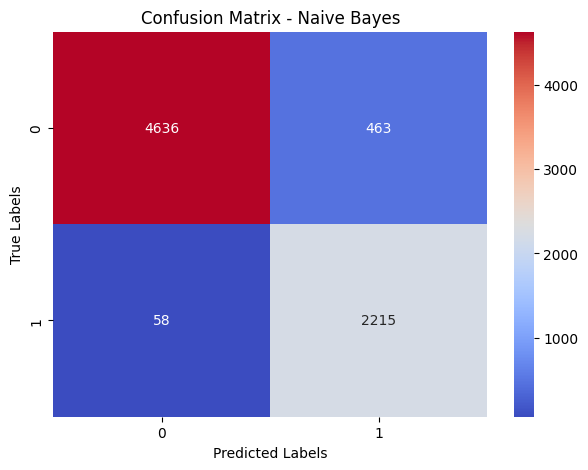

In [344]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_NB,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [345]:
naive_acc=accuracy_score(y_test,y_pred_NB)
naive_acc

0.9293271839392295

#### 3.2.2 - Decision Tree

In [346]:
clf_DecisionTree= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('dt',DecisionTreeClassifier())
])

In [347]:
clf_DecisionTree.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('dt', DecisionTreeClassifier())])

In [348]:
y_pred_DT=clf_DecisionTree.predict(X_test)

In [349]:
# Plot Confusion Matrix
conf_mat_DT=confusion_matrix(y_test, y_pred_DT)

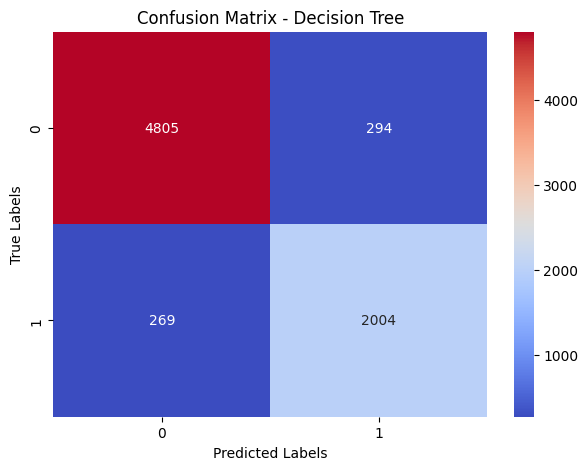

In [350]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_DT,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [351]:
dt_acc=accuracy_score(y_test,y_pred_DT)
dt_acc

0.9236299511665762

#### 3.2.3 - Random Forest

In [352]:
clf_rf= Pipeline([
    ('vectorizer', CountVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100))
])

In [353]:
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('rf', RandomForestClassifier())])

In [354]:
y_pred_RF=clf_rf.predict(X_test)

In [355]:
conf_mat_RF=confusion_matrix(y_test, y_pred_RF)

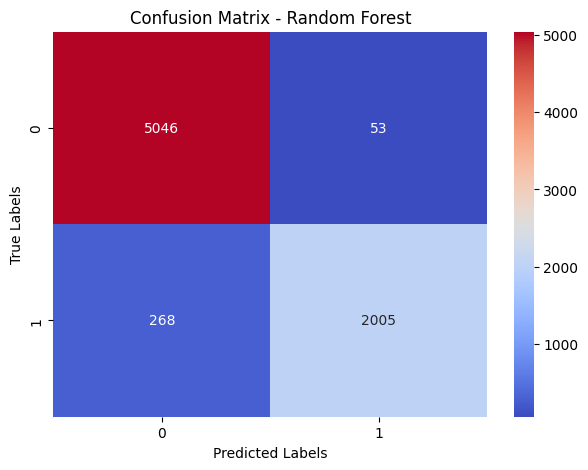

In [356]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_RF,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [357]:
rf_acc=accuracy_score(y_test,y_pred_RF)
rf_acc

0.9564568638090071

## 4 - Testing the Model

In [358]:
def spam_dect(clf,txt):
    a=clf.predict([txt])
    if a==1:
        print("This is a Spam email")
    else:
        print("This is a Real email")

In [401]:
#Demo email, copy the content into the " "
test_email_1="Remember: you can try Academia Premium for $3 for 30 days"
test_email_2="OpenAI launches its most advanced AI model for deeper problem-solving"

In [402]:
#Predict with Random Forest
spam_dect(clf_rf,test_email_1)

This is a Real email


In [403]:
spam_dect(clf_rf,test_email_2)

This is a Real email
